In [1]:
# importing required libraries
import os
import pandas as pd
import numpy as np
import re

# storing all file names in a list
file_names = os.listdir(path='documents/')
print(len(file_names))

18828


In [2]:
# extracting class labels from the file names
class_labels = []
for file in file_names:
    label = file.split('_')[0]
    class_labels.append(label)

print(f'The number of unique classes are {len(set(class_labels))}')

The number of unique classes are 20


In [3]:
# creating a data frame to store file id and class labels
df = pd.DataFrame(data = {'file_id': file_names,'class_label':class_labels})
df.head(5)

,file_id,class_label
0,alt.atheism_49960.txt,alt.atheism
1,alt.atheism_51060.txt,alt.atheism
2,alt.atheism_51119.txt,alt.atheism
3,alt.atheism_51120.txt,alt.atheism
4,alt.atheism_51121.txt,alt.atheism


# Text Processing

### Defining Utility Functions

In this section we will be defining all the necessary utility functions required in order to perform text preprocessing.

In [4]:
def email_processing(document):
    '''
    This function takes a document as input and 
    returns pre-processed emails as its output
    '''
    
    # compiling pattern to search for 
    # reference https://stackoverflow.com/questions/17681670/extract-email-sub-strings-from-large-document
    pattern = re.compile(r'[\w\.-]+@[\w\.-]+\.\w+')
    email_list = re.findall(pattern,document)
    
    # preprocessing all the emails found to get the final output
    output_list = []
    for email in email_list:
        domain = (email.split('@')[1]).split('.') # extracting domain name and splitting based on .
        temp_list = [x for x in domain if len(x) > 2 and x!= 'com'] # removing characters based on conditions
        output_list.extend(temp_list)
    
    # combining all characters into a single string
    output = ' '.join(output_list)
    
    # converting all characters to lowercase
    output = output.lower()
    
    # removing all emails found from the document
    document = re.sub(pattern,' ',document)
        
    return output, document
    

In [5]:
def subject_processing(document):
    '''    
    This function takes a document as input and 
    returns pre-processed emails as its output
    '''
    
    # looping through each line in our document to find subject line
    for line in document.split('\n'):
        if line.startswith('Subject:'):
            sub_line = line
            break
    
    # extracting only words after ':' in subject   
    processed_sub = sub_line.split(':')[-1] 
    
    # removing special characters etc from subject line
    processed_sub = re.sub('\\r', ' ', processed_sub)
    processed_sub = re.sub('\\n', ' ', processed_sub)
    processed_sub = re.sub('\\t', ' ', processed_sub)
    processed_sub = re.sub('[^A-Za-z]+',' ',processed_sub)
    processed_sub = processed_sub.strip() 
    
    # converting all characters to lowercase
    processed_sub = processed_sub.lower()
    
    # removing subject line from document
    document = document.replace(sub_line,' ')
    
    
    return processed_sub,document

In [6]:
def remove_from_to(document):
    '''
    This function removes those lines which start with "from:"
    and "write to:"
    '''
    
    processed_document = document
    
    # looping through the document to check if any sentences start with 'from:' or 'write to:'
    for line in document.split('\n'):
        if line.startswith('From:') or line.startswith('Write to:'):
            # removing those sentences from processed document
            processed_document = processed_document.replace(line, ' ')
    
    return processed_document        

In [7]:
# https://stackoverflow.com/a/47091490/4084039
def decontracted(phrase):
    '''
    This function decontracts words like won't to will not
    '''

    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    return phrase

In [8]:
from nltk import ne_chunk, pos_tag, word_tokenize, sent_tokenize 

# https://stackoverflow.com/questions/31836058/nltk-named-entity-recognition-to-a-python-list/31837224#31837224
def chunking(document):
    '''
    This function chunks the document in order to remove any names(person)
    and to combine named entities having spaces with '_'
    '''
    
    named_entities = [] # list to store all named entities other than person
    person = []
    
    # tokenizing document into sentences
    for sent in sent_tokenize(document):
        # getting the named entity chunks after POS tagging
        for chunk in ne_chunk(pos_tag(word_tokenize(sent))):
            if hasattr(chunk,'label'):
                entity = ' '.join(c[0] for c in chunk)
                # filtering out named entities which are not a person but need to be combined
                if chunk.label() != 'PERSON' and len(entity.split()) > 1:
                    named_entities.append(entity)
                elif chunk.label() == 'PERSON':
                    person.append(entity)
    
    # removing person entities from the document
    for name in person:
        document = document.replace(name,' ')
    
    # combining other named entities with '_'
    for ent in named_entities:
        join_ent = '_'.join(ent.split())
        document = document.replace(ent,join_ent)
    
    return document
        

In [9]:
def remove_underscore(document):
    '''
    This function helps to remove underscores from words in the
    document
    '''
    
    # finding words with '_' at the beginning as well as end
    pattern_1 = re.compile(r'\b_[^_\s]+_\b')
    words_1 = re.findall(pattern_1,document)
    
    # finding words with '_' only at the beginning
    pattern_2 = re.compile(r'\b_[^_\s]+\b')
    words_2 = re.findall(pattern_2,document)
    
    # finding words with '_' only at the end
    pattern_3 = re.compile(r'\b[^_\s]+_\b')
    words_3 = re.findall(pattern_3,document)
    
    # combining all words found and removing underscores from them
    all_words = words_1 + words_2 + words_3
    
    for word in all_words:
        updated_word = word.replace('_','')
        document = document.replace(word,updated_word)
    
    return document    

In [10]:
def remove_before_underscore(document):
    '''
    This function removes words before underscores
    which have less than or equal to 2 characters
    '''
    
    # finding words which have 1 or 2 characters before an underscore
    pattern = re.compile(r'\b[^_\s]{1,2}_[^_\s]+\b')

    words = re.findall(pattern,document)
    
    # removing characters before underscore
    for word in words:
        updated_word = word.split('_')[1]
        document = document.replace(word,updated_word)
    
    return document
    

In [11]:
def final_processing(document):
    '''
    In this function we will perform the final pre processing steps
    required on our text data
    '''
    
    # convert all words to lowercase
    document = document.lower()
    
    # removing all words less than 2 or greater than 15
    # https://www.daniweb.com/programming/software-development/threads/382016/remove-words-with-less-than-n-letters-from-wordlist
    document = ' '.join([x for x in document.split() if 2 < len(x) < 15])
    
    # ensuring that our document contains only [A-Za-z_]
    pattern = re.compile(r'[^A-Za-z_]')
    document = re.sub(pattern,' ',document)
    
    # stripping any spaces at the end and joining all words again to ensure there are no spaces 
    document = ' '.join(document.split())
    document = document.strip()
    
    return document
    
    

In [12]:
def text_processing(input_text):
    '''
    This function performs all the preprocessing steps 
    required in order to convert raw text data into final 
    preprocessed form
    '''
    
    # email preprocessing 
    processed_emails, processed_text = email_processing(input_text)
    
    # subject preprocessing
    processed_subjects, processed_text = subject_processing(processed_text)
    
    # removing sentences which start with from or write to
    processed_text = remove_from_to(processed_text)
    
    # miscellaneous preprocessing steps
    processed_text =  re.sub(r'<.*\>',' ',processed_text) # removes words angular brackets "<>"
    processed_text =  re.sub(r'\([^)]+\)',' ',processed_text) # removes words in paranthesis "()"
    processed_text =  re.sub(r'\b[\w]+:',' ',processed_text) # removes words that end with ":"
    
    # removing tabs, newlines etc.
    processed_text = re.sub(r'\\',' ',processed_text)
    processed_text = re.sub(r'\t',' ',processed_text)
    processed_text = re.sub(r'\n',' ',processed_text)
    processed_text = re.sub(r'-',' ',processed_text)
    
    # decontracting of words
    processed_text = decontracted(processed_text)
    
    # chunking of text 
    processed_text = chunking(processed_text)
    
    # replacing all digits with space 
    processed_text = re.sub(r'[0-9]',' ',processed_text)
    
    # removing underscores from words
    processed_text = remove_underscore(processed_text)
    
    # removing characters before an underscore
    processed_text = remove_before_underscore(processed_text)
    
    # performing final processing step 
    processed_text = final_processing(processed_text)
    
    return processed_emails, processed_subjects, processed_text

## Sample Preprocessing

We will be applying the above text processing function defined on a sample document **'alt.atheism_49960'**

In [13]:
with open('documents/alt.atheism_49960.txt') as f:
    text = f.read()
    email, subject, proc_text = text_processing(text)
    print('Emails:')
    print('')
    print(email)
    print('')
    print('Subject:')
    print('')
    print(subject)
    print('')
    print('Processed Text:')
    print('')
    print(proc_text)


Emails:

mantis netcom mantis

Subject:

atheist resources

Processed Text:

archive alt atheism archive resources last december atheist resources addresses usa freedom from religion foundation fish bumper stickers and assorted other atheist paraphernalia are available from the the us evolution designs evolution designs sell the fish fish symbol like the ones stick their cars but with feet and the word written inside the deluxe moulded plastic fish postpaid the us people the area can get fish from try mailing for net people who directly the price per fish american atheist press aap publish various atheist books critiques the bible lists biblical and on one such book the w p ball and g w foote american pp isbn edition bible absurdities atrocities contains ball the aap based the king version the bible austin prometheus books sell books including holy_horrors alternate address prometheus african americans_for humanism organization promoting black secular humanism and uncovering the histor

## Processing All Documents

Now we will be processing all documents and storing them in a dataframe

In [14]:
from tqdm import tqdm

raw_text_list = []
processed_emails_list = []
processed_subjects_list = []
processed_documents_list = []

# looping through all the documents and processing them 
for file in tqdm(df['file_id']):
    with open(f'documents/{file}') as f:
        document_text = f.read()
        processed_email, processed_subject, processed_document = text_processing(document_text)
        
        # appending to appropriate lists defined above
        raw_text_list.append(document_text)
        processed_emails_list.append(processed_email)
        processed_subjects_list.append(processed_subject)
        processed_documents_list.append(processed_document)        

100%|████████████████████████████████████████████████████████████████████████████| 18828/18828 [23:00<00:00, 13.64it/s]


In [15]:
# adding processed data to dataframe
df['text'] = raw_text_list
df['processed_email'] = processed_emails_list
df['processed_subject'] = processed_subjects_list
df['processed_text'] = processed_documents_list
df.head(5)

,file_id,class_label,text,processed_email,processed_subject,processed_text
0,alt.atheism_49960.txt,alt.atheism,From: mathew <mathew@mantis.co.uk>\nSubject: A...,mantis netcom mantis,atheist resources,archive alt atheism archive resources last dec...
1,alt.atheism_51060.txt,alt.atheism,From: mathew <mathew@mantis.co.uk>\nSubject: A...,mantis mantis mantis,introduction to atheism,archive alt atheism archive introduction last ...
2,alt.atheism_51119.txt,alt.atheism,From: I3150101@dbstu1.rz.tu-bs.de (Benedikt Ro...,dbstu1 tu-bs mimsy umd edu umd edu,gospel dating,article well has quite different not necessari...
3,alt.atheism_51120.txt,alt.atheism,From: mathew <mathew@mantis.co.uk>\nSubject: R...,mantis kepler unh edu,university violating separation of church state,recently ras have been ordered post religious ...
4,alt.atheism_51121.txt,alt.atheism,From: strom@Watson.Ibm.Com (Rob Strom)\nSubjec...,watson ibm com harder ccr-p ida org harder ccr...,soc motss et al princeton axes matching funds ...,article however hate economic terrorism and po...


In [16]:
# dumping the dataframe to a pickle file
df.to_pickle("final_df.pkl")

# Loading & Preparing Data

In [4]:
# loading saved pickle file
import numpy as np
import pandas as pd
import tensorflow as tf

data = pd.read_pickle('final_df.pkl')
data.head(5)

,file_id,class_label,text,processed_email,processed_subject,processed_text
0,alt.atheism_49960.txt,alt.atheism,From: mathew <mathew@mantis.co.uk>\nSubject: A...,mantis netcom mantis,atheist resources,archive alt atheism archive resources last dec...
1,alt.atheism_51060.txt,alt.atheism,From: mathew <mathew@mantis.co.uk>\nSubject: A...,mantis mantis mantis,introduction to atheism,archive alt atheism archive introduction last ...
2,alt.atheism_51119.txt,alt.atheism,From: I3150101@dbstu1.rz.tu-bs.de (Benedikt Ro...,dbstu1 tu-bs mimsy umd edu umd edu,gospel dating,article well has quite different not necessari...
3,alt.atheism_51120.txt,alt.atheism,From: mathew <mathew@mantis.co.uk>\nSubject: R...,mantis kepler unh edu,university violating separation of church state,recently ras have been ordered post religious ...
4,alt.atheism_51121.txt,alt.atheism,From: strom@Watson.Ibm.Com (Rob Strom)\nSubjec...,watson ibm com harder ccr-p ida org harder ccr...,soc motss et al princeton axes matching funds ...,article however hate economic terrorism and po...


In [5]:
# combining the email, subject and text columns
data['combined_text'] = data['processed_email'] + ' ' + data['processed_subject'] + ' ' + data['processed_text']
data.head()

,file_id,class_label,text,processed_email,processed_subject,processed_text,combined_text
0,alt.atheism_49960.txt,alt.atheism,From: mathew <mathew@mantis.co.uk>\nSubject: A...,mantis netcom mantis,atheist resources,archive alt atheism archive resources last dec...,mantis netcom mantis atheist resources archive...
1,alt.atheism_51060.txt,alt.atheism,From: mathew <mathew@mantis.co.uk>\nSubject: A...,mantis mantis mantis,introduction to atheism,archive alt atheism archive introduction last ...,mantis mantis mantis introduction to atheism a...
2,alt.atheism_51119.txt,alt.atheism,From: I3150101@dbstu1.rz.tu-bs.de (Benedikt Ro...,dbstu1 tu-bs mimsy umd edu umd edu,gospel dating,article well has quite different not necessari...,dbstu1 tu-bs mimsy umd edu umd edu gospel dati...
3,alt.atheism_51120.txt,alt.atheism,From: mathew <mathew@mantis.co.uk>\nSubject: R...,mantis kepler unh edu,university violating separation of church state,recently ras have been ordered post religious ...,mantis kepler unh edu university violating sep...
4,alt.atheism_51121.txt,alt.atheism,From: strom@Watson.Ibm.Com (Rob Strom)\nSubjec...,watson ibm com harder ccr-p ida org harder ccr...,soc motss et al princeton axes matching funds ...,article however hate economic terrorism and po...,watson ibm com harder ccr-p ida org harder ccr...


In [6]:
# converting the class labels to integer
data['class_label'] = data['class_label'].astype('category').cat.codes
data.head()

,file_id,class_label,text,processed_email,processed_subject,processed_text,combined_text
0,alt.atheism_49960.txt,0,From: mathew <mathew@mantis.co.uk>\nSubject: A...,mantis netcom mantis,atheist resources,archive alt atheism archive resources last dec...,mantis netcom mantis atheist resources archive...
1,alt.atheism_51060.txt,0,From: mathew <mathew@mantis.co.uk>\nSubject: A...,mantis mantis mantis,introduction to atheism,archive alt atheism archive introduction last ...,mantis mantis mantis introduction to atheism a...
2,alt.atheism_51119.txt,0,From: I3150101@dbstu1.rz.tu-bs.de (Benedikt Ro...,dbstu1 tu-bs mimsy umd edu umd edu,gospel dating,article well has quite different not necessari...,dbstu1 tu-bs mimsy umd edu umd edu gospel dati...
3,alt.atheism_51120.txt,0,From: mathew <mathew@mantis.co.uk>\nSubject: R...,mantis kepler unh edu,university violating separation of church state,recently ras have been ordered post religious ...,mantis kepler unh edu university violating sep...
4,alt.atheism_51121.txt,0,From: strom@Watson.Ibm.Com (Rob Strom)\nSubjec...,watson ibm com harder ccr-p ida org harder ccr...,soc motss et al princeton axes matching funds ...,article however hate economic terrorism and po...,watson ibm com harder ccr-p ida org harder ccr...


In [7]:
X = data['combined_text']
Y = data['class_label']

In [8]:
# splitting our data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.25,stratify=Y,random_state=23)
print(f'The number of points in training data: {X_train.shape[0]}')
print(f'The number of points in test data: {X_test.shape[0]}')

The number of points in training data: 14121
The number of points in test data: 4707


In [9]:
# converting class labels into one hot encoded vectors
y_train = tf.keras.utils.to_categorical(y_train, 20)
y_test = tf.keras.utils.to_categorical(y_test, 20)

## Tokenizing Text Data

### Determining Maximum Number of Words

Now in order to decide the maximum number of words to keep in our vocabulary we will follow the below steps:
- Find out total number of unique words in our training data (m)
- Find out the number of words which occur less than or equal to two times (n)
- We will then keep only the (m - n) top words, i.e. eliminate all words which occur only once

In essence we will be only keeping those words which occur atleast twice in our corpus.

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer

# initially we will tokenize the corpus without passing any parameter for num_words 

word_tokenizer = Tokenizer(num_words=None,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n') # filter inludes all special characters except '_'
word_tokenizer.fit_on_texts(X_train)
total_words = len(word_tokenizer.word_index)
print(f'Number of unique words in vocabulary: {total_words}')


Number of unique words in vocabulary: 72468


In [11]:
# finding the number of words which occur only twice or less
num_words = 0
for word,count in word_tokenizer.word_counts.items():
    if count < 2:
        num_words += 1

print(f'Number of words which in our vocabulary which occur twice or less: {num_words}')

# finding max number of words we need to consider
max_words = total_words - num_words
print(f'Number of words which occur at least two times: {max_words}')
    

Number of words which in our vocabulary which occur twice or less: 28344
Number of words which occur at least two times: 44124


Hence we will be only considering the top 44,124 words from our vocabulary

### Determining Max Length for Padding

In order to determine the appropriate max length for padding our documents we will be analyzing the percentiles of document lengths in our training dataset

In [12]:
# storing all document lengths in a list
document_lengths = []

for doc in X_train:
    length = len(doc.split())
    document_lengths.append(length)

# finding the percentile values from 0 to 100 incrementing by 10 each iteration
for i in range(0,110,10):
    per_val = np.percentile(document_lengths,i)
    print(f'{i} percentile value is {per_val}')

0 percentile value is 3.0
10 percentile value is 39.0
20 percentile value is 57.0
30 percentile value is 73.0
40 percentile value is 90.0
50 percentile value is 110.0
60 percentile value is 135.0
70 percentile value is 169.0
80 percentile value is 221.0
90 percentile value is 337.0
100 percentile value is 8802.0


As observed there is a significant jump between 90th and 100th percentile value and hence we should zoom in further in this range to analyze the document lengths.

In [13]:
# finding the percentile values between 90 and 100 incrementing by 1 each iteration
for i in range(90,101):
    per_val = np.percentile(document_lengths,i)
    print(f'{i} percentile value is {per_val}')

90 percentile value is 337.0
91 percentile value is 356.0
92 percentile value is 383.0
93 percentile value is 422.60000000000036
94 percentile value is 458.0
95 percentile value is 510.0
96 percentile value is 573.1999999999989
97 percentile value is 685.0
98 percentile value is 890.0
99 percentile value is 1369.5999999999985
100 percentile value is 8802.0


As observed from the above percentile values 95% of the documents have a length of less than around 500 tokens. We can consider this as the max length for padding our sequences as we can retain information in most of our documents and also not have too much of an impact on the computational power required.

### Tokenizing and Padding
    

In [14]:
# we will now fit the tokenizer on the training data and convert train and text into integer sequences along with padding

word_tokenizer = Tokenizer(num_words=max_words + 1,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n') # filter inludes all special characters except '_'
word_tokenizer.fit_on_texts(X_train)

# converting train and test into integere sequences
x_train = word_tokenizer.texts_to_sequences(X_train)
x_test = word_tokenizer.texts_to_sequences(X_test)

In [15]:
# printing output of a single document
print(x_train[23])

[9802, 9501, 8686, 10, 9501, 8686, 10, 9802, 53, 140, 23, 8687, 5836, 4369, 26, 1232, 21722, 28, 256, 4369, 344, 2, 97, 175, 887, 5836, 4369, 298, 5422, 8, 1, 256, 24169, 11240, 432, 145, 1, 693, 3378, 1, 2140, 6047, 60, 5422, 145, 1, 693, 2140, 1346, 1, 19680, 3, 28, 4024, 7, 1, 11, 693, 2, 3, 60, 4024, 1, 693, 2140, 12, 3277, 1, 99, 563, 1, 2841, 2140, 155, 85, 140, 189, 3, 15, 7, 1, 99, 2413, 1782, 5177, 1, 4209, 18, 1, 2841, 96, 1, 693, 2564, 80, 21723, 11240, 7009, 5422, 19, 241, 11, 1873, 85, 178, 178, 1, 693, 2140, 6, 1011, 401, 883, 2862, 164, 832, 1868, 9, 316, 3, 20, 1673, 2485, 1566, 228, 883, 1265, 2285, 1, 693, 2140, 68, 5, 8, 6875, 28, 43, 72, 1, 99, 58, 1, 2841, 2140, 77, 1931, 100, 1, 660, 6, 1, 1419, 2140, 110, 401, 15775, 38, 20, 2485, 1566, 5, 2268, 1845, 1451, 66, 1519, 8437, 6875, 5836, 5, 17, 3200, 1844, 5837, 462, 163, 2841, 2, 693, 14, 8, 883, 1751, 645, 1, 4423, 2560, 13, 3313, 2427, 3313, 240, 19, 5, 17, 5, 91, 279, 11240, 5422, 145, 1470, 4369, 55, 12805, 583

In [16]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# padding of all sequences to max length of 500
max_length = 500

x_train = pad_sequences(sequences=x_train, maxlen=max_length, padding='post', truncating='post')
x_test = pad_sequences(sequences=x_test, maxlen=max_length, padding='post', truncating='post')

print(f'Shape of Training Data: {x_train.shape}')
print(f'Shape of Test Data: {x_test.shape}')

Shape of Training Data: (14121, 500)
Shape of Test Data: (4707, 500)


## Loading Pre-Defined Glove Vectors

We will be loading pre-defined glove vectors and use them in our embedding layer. We will be using 300 dimensional representation which have been trained on 42B tokens.

https://nlp.stanford.edu/projects/glove/

In [34]:
# reference https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

# loading pre-defined word embeddings and storing them as a dict
word_embeddings = dict()
with open('glove.42B.300d.txt',encoding='utf-8') as f:
    for line in tqdm(f):
        # extracting the token and corresponsing embedding
        token = line.split()[0]  
        vector = np.asarray(line.split()[1:], dtype='float32')
        word_embeddings[token] = vector
        
print(f'Loaded 300d vector representations corresponding to {len(word_embeddings)} words')        

1917494it [06:41, 4770.72it/s]

Loaded 300d vector representations corresponding to 1917494 words


In [56]:
# creating a weight matrix for words in our training vocab
vocab_size = max_words + 1
embedding_matrix = np.zeros((vocab_size,300))

for word,index in tokenizer.word_index.items():
    # only considering max words
    if index < vocab_size:
        glove_vector = word_embeddings.get(word)
        # updating our weight matrix if glove vector corresponding to word exists
        if glove_vector is not None:
            embedding_matrix[index] = glove_vector
            
print(f'Shape of Embedding Matrix {embedding_matrix.shape}')        

Shape of Embedding Matrix (44125, 300)


In [57]:
# saving our embedding matrix on disk
np.save('word_embedding_matrix.npy',embedding_matrix)

In [17]:
# loading our embedding matrix
with open('word_embedding_matrix.npy','rb') as f:
    word_embedding_matrix = np.load(f)

print(word_embedding_matrix.shape)

(44125, 300)


## Defining Callbacks

In [18]:
%load_ext tensorboard
import datetime

In [19]:
# callback for custom metric: micro_f1_score
# reference: https://stackoverflow.com/questions/60616842/how-to-get-other-metrics-in-tensorflow-2-0-not-only-accuracy
from sklearn.metrics import f1_score

class CustomMetrics(tf.keras.callbacks.Callback):

    def __init__(self,val_data,val_labels):
        '''
        This function initializes callback object to 
        compute custom metrics
        '''
        self.val_data = val_data
        self.val_labels = val_labels
    
    def on_epoch_end(self,epoch,logs={}):
        '''
        This function computes the micro f1 score at 
        the end of each epoch
        '''
        
        # getting the true class labels
        val_true_labels = np.argmax(self.val_labels, axis=1)

        # predicting the class labels of validation set
        val_pred_labels = np.argmax(self.model.predict(self.val_data), axis=1)

        # computing the micro f1 score
        micro_f1 = f1_score(val_true_labels,val_pred_labels,average='micro')

        print(f'micro_f1_score: {round(micro_f1,4)}')


def tf_callback(model_num=None):
    '''
    This function returns a tensorboard callback object
    '''
    
    # specifiying the directory structure and instantiating tensorboard callback object
    log_dir = f"logs/fit/{model_num}/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    
    return cb

## Defining Model Architecture

In [22]:
# reference paper: https://cs230.stanford.edu/files_winter_2018/projects/6937311.pdf
from tensorflow.keras import Input
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# defining kernel initializer and regularizer
initializer = HeNormal()
regularizer = L2(l2=0.01)

# defining input and embedding layers
input_layer = Input(shape=(max_length,))
embedding = Embedding(input_dim=vocab_size,output_dim=300,input_length=max_length,weights=[word_embedding_matrix],trainable=False)(input_layer)

# defining the first set of conv1d layers
conv_a_1 = Conv1D(50,3,1,activation='relu',kernel_initializer=initializer,padding='same')(embedding)
conv_a_2 = Conv1D(50,4,1,activation='relu',kernel_initializer=initializer,padding='same')(embedding)
conv_a_3 = Conv1D(50,5,1,activation='relu',kernel_initializer=initializer,padding='same')(embedding)

# concatenating and max pool first set of conv1d layers
concat_a = concatenate([conv_a_1,conv_a_2,conv_a_3])
maxpool_a = MaxPooling1D(pool_size=2,strides=1)(concat_a)

# defining the second set of conv1d layers
conv_b_1 = Conv1D(50,3,1,activation='relu',kernel_initializer=initializer,padding='same')(maxpool_a)
conv_b_2 = Conv1D(50,4,1,activation='relu',kernel_initializer=initializer,padding='same')(maxpool_a)
conv_b_3 = Conv1D(50,5,1,activation='relu',kernel_initializer=initializer,padding='same')(maxpool_a)

# concatenating and max pool second set of conv1d layers
concat_b = concatenate([conv_b_1,conv_b_2,conv_b_3])
maxpool_b = MaxPooling1D(pool_size=2,strides=1)(concat_b)

# final conv1d layer and dense layers
conv_c = Conv1D(50,5,1,activation='relu',kernel_initializer=initializer)(maxpool_b)
flatten = Flatten()(conv_c)
drop_1 = Dropout(rate=0.5)(flatten)
dense_1 = Dense(units=32,activation='relu',kernel_initializer=initializer,kernel_regularizer=regularizer)(drop_1)
output_layer = Dense(units=20,activation='softmax',kernel_initializer=initializer)(dense_1)

# creating the model
model = Model(inputs=input_layer,outputs=output_layer)

# defining callbacks
early_stop = EarlyStopping(monitor='val_accuracy',min_delta=0.02,patience=1,mode='auto',verbose=1)
checkpoint = ModelCheckpoint(filepath='models/best_model_1.h5',monitor='val_accuracy',
                             verbose=0,save_best_only=True,save_weights_only=True,mode='auto')
metric_callback = CustomMetrics(x_test,y_test)
tensorboard = tf_callback(model_num=1)
callbacks = [early_stop,checkpoint,metric_callback,tensorboard]


# compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 500, 300)     13237500    input_2[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 500, 50)      45050       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 500, 50)      60050       embedding[0][0]                  
______________________________________________________________________________________________

In [23]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),batch_size=16,epochs=50,callbacks=callbacks)

Epoch 1/50
883/883 [==============================] - 126s 142ms/step - loss: 2.8258 - accuracy: 0.1729 - val_loss: 1.4304 - val_accuracy: 0.6507
micro_f1_score: 0.6507
Epoch 2/50
883/883 [==============================] - 152s 172ms/step - loss: 1.3053 - accuracy: 0.6869 - val_loss: 1.0926 - val_accuracy: 0.7684
micro_f1_score: 0.7684
Epoch 3/50
883/883 [==============================] - 154s 174ms/step - loss: 0.8970 - accuracy: 0.8244 - val_loss: 0.9752 - val_accuracy: 0.8088
micro_f1_score: 0.8088
Epoch 4/50
883/883 [==============================] - 153s 173ms/step - loss: 0.7558 - accuracy: 0.8738 - val_loss: 0.9048 - val_accuracy: 0.8434
micro_f1_score: 0.8434
Epoch 5/50
883/883 [==============================] - 151s 171ms/step - loss: 0.6419 - accuracy: 0.9057 - val_loss: 0.9492 - val_accuracy: 0.8458
micro_f1_score: 0.8458
Epoch 00005: early stopping


<img src="https://i.imgur.com/uznl2zs.png" width=400>
<img src="https://i.imgur.com/Jcz4lQ7.png" width=400>




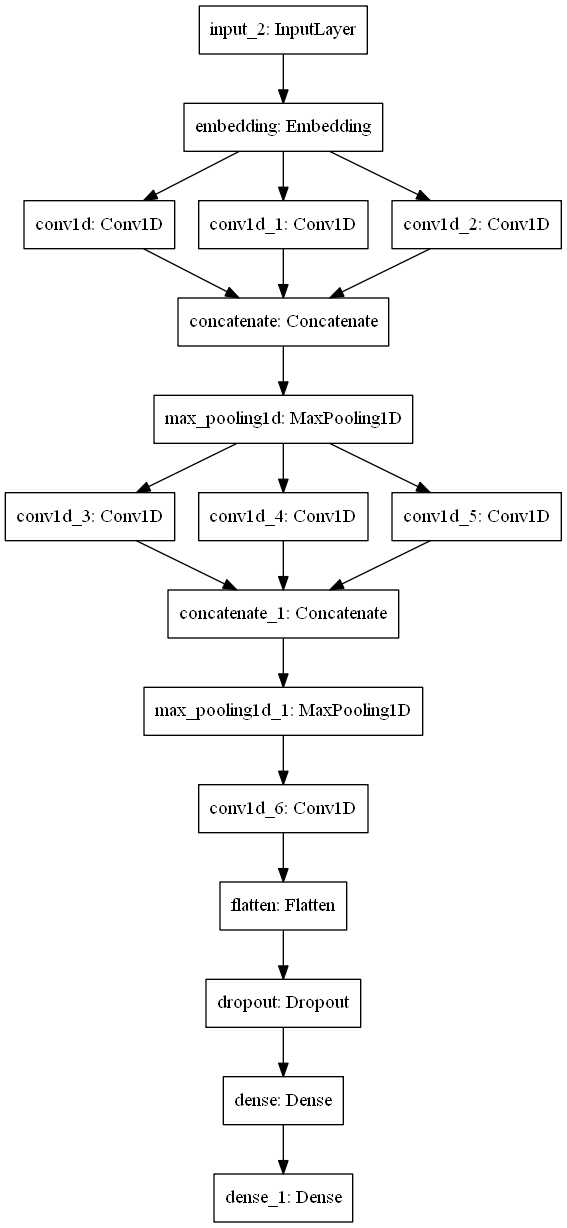

In [23]:
# plotting model 
from tensorflow.keras.utils import plot_model
path = 'images/plots/model_1.png'
plot_model(model,to_file=path)